In [0]:
%tensorflow_version 1.x
import os
import keras
import random as rm
import numpy as np
import tensorflow as tf
from random import randint
import matplotlib.pyplot as plt
from keras import backend as k
import pprint

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import *
from keras.layers.convolutional import Convolution2D,MaxPooling2D
from keras.optimizers import adam
from keras.metrics import categorical_crossentropy, binary_crossentropy, mean_squared_error

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 


TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
tf.__version__

'1.15.2'

Set up the TPU environment

In [0]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; ')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

TPU address is grpc://10.24.148.10:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 14461651283611509223),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 7726456606115542055),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 7762979226194945032),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 12594061900170413215),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 15841890095405061381),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 14003186494632494769),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 3948579546210188516),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 775841552312129082),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 7924610320520

In [0]:
# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926
os.environ['PYTHONHASHSEED']='0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(37)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rm.seed(1245)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(123)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

sess=tf.Session(graph=tf.get_default_graph())
k.set_session(sess)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#  import zipfile
#  with zipfile.ZipFile("/content/drive/My Drive/Grad/789 deep learning/Presentation/XRays/covid.zip","r") as zip_ref:
#       zip_ref.extractall("/content/drive/My Drive/Grad/789 deep learning/Presentation/XRays")

In [0]:
pp='/content/drive/My Drive/Grad/789 deep learning/Presentation/XRays/'
train_path=pp+'xray_dataset_covid19/train/'
test_path=pp+'xray_dataset_covid19/test/'

In [0]:
#batch size=7

img_size=224
datagen = ImageDataGenerator(rescale=1./255)
train_batches=datagen.flow_from_directory(
               train_path,
               target_size=(img_size,img_size),
               classes=['NORMAL','PNEUMONIA'],
               batch_size=7, # divided evenly with training data set
               color_mode="grayscale",
               shuffle=False
               )

test_batches=datagen.flow_from_directory(
               test_path,
               target_size=(img_size,img_size),
               classes=['NORMAL','PNEUMONIA'],
               batch_size=5, 
               color_mode="grayscale",
               shuffle=False
               )

Found 147 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


# XRay Images labeling

In [0]:
img,lables=next(train_batches)
np.shape(img)

(7, 224, 224, 1)

In [0]:
#Here the picture is 224,224 and 1 is showing the grayscale. if we use RBG the 1 will convert to 3
np.shape(img[0])

(224, 224, 1)

In [0]:
np.shape(img[0][:,:,0])

(224, 224)

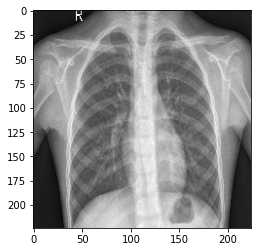

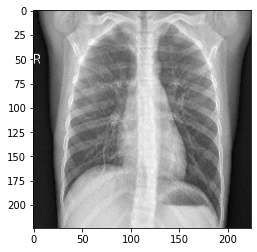

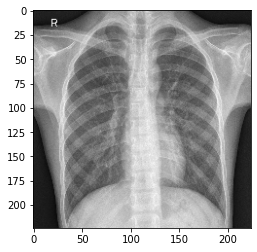

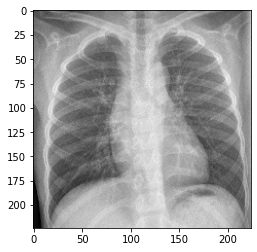

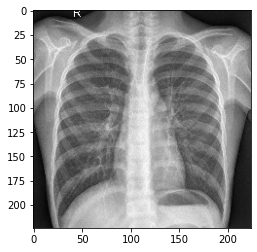

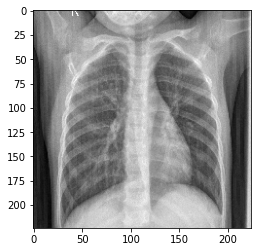

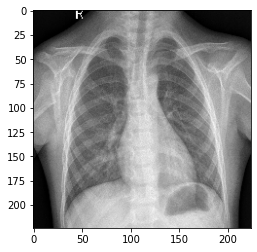

In [0]:
for i in range(0,7):
    image = img[i]
    plt.imshow(image[:,:,0], cmap='gray')
    plt.show()

# Build Convolutional Neural Networks

In [0]:
# here we can replace img.shape[1:] by (224,224,1)
model1=Sequential()
model1.add(Convolution2D(16,(3,3),input_shape=img.shape[1:])) # 16: filter size (int); kernel size
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Convolution2D(32,(3,3),input_shape=img.shape[1:]))
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Convolution2D(64,(3,3),input_shape=img.shape[1:]))
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size=(2,2)))

# Dense layer is one dimentional data set while convolution is 2 dimentional dataset
model1.add(Flatten())
model1.add(Activation("relu"))

model1.add(Dense(64))
model1.add(Activation("relu"))

model1.add(Dense(2))
model1.add(Activation(tf.nn.softmax)) #sigmoid

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [0]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 16)      160       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)       

In [0]:
model1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
history_1=model1.fit_generator(
    generator=train_batches,
    steps_per_epoch=21, # = sample length / batch_size
    epochs=10,
    verbose=2
)


Epoch 1/10
 - 48s - loss: 0.7989 - categorical_accuracy: 0.5782
Epoch 2/10
 - 10s - loss: 0.6667 - categorical_accuracy: 0.6531
Epoch 3/10
 - 10s - loss: 0.4235 - categorical_accuracy: 0.8707
Epoch 4/10
 - 10s - loss: 0.2123 - categorical_accuracy: 0.8980
Epoch 5/10
 - 10s - loss: 0.2270 - categorical_accuracy: 0.9116
Epoch 6/10
 - 10s - loss: 0.2282 - categorical_accuracy: 0.9456
Epoch 7/10
 - 10s - loss: 0.0953 - categorical_accuracy: 0.9660
Epoch 8/10
 - 10s - loss: 0.0676 - categorical_accuracy: 0.9728
Epoch 9/10
 - 10s - loss: 0.0742 - categorical_accuracy: 0.9796
Epoch 10/10
 - 10s - loss: 0.1020 - categorical_accuracy: 0.9660


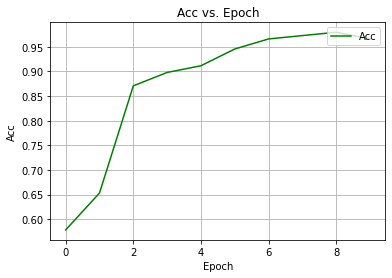

In [0]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.grid()
#pyplot.plot(history_1.history['loss'],color='green')
pyplot.plot(history_1.history['categorical_accuracy'],color='green')
plt.title('Acc vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(['Acc'],loc='upper right')

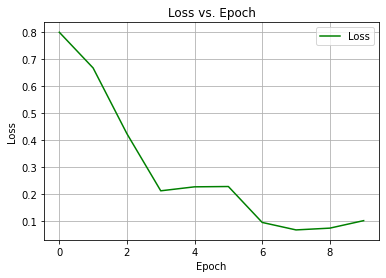

In [0]:
plt.grid()
#pyplot.plot(history_1.history['loss'],color='green')
pyplot.plot(history_1.history['loss'],color='green')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Loss'],loc='upper right')

In [0]:
#batch size=3:

img_size=224
datagen = ImageDataGenerator(rescale=1./255)
train_batches=datagen.flow_from_directory(
               train_path,
               target_size=(img_size,img_size),
               classes=['NORMAL','PNEUMONIA'],
               batch_size=3, # divided evenly with training data set
               color_mode="grayscale",
               shuffle=False
               )

test_batches=datagen.flow_from_directory(
               test_path,
               target_size=(img_size,img_size),
               classes=['NORMAL','PNEUMONIA'],
               batch_size=5, 
               color_mode="grayscale",
               shuffle=False
               )


img,lables=next(train_batches)
np.shape(img)

Found 147 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


(3, 224, 224, 1)

In [0]:
# here we can replace img.shape[1:] by (224,224,1)
model2=Sequential()
model2.add(Convolution2D(16,(3,3),input_shape=img.shape[1:])) # 16: filter size (int); kernel size
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Convolution2D(32,(3,3),input_shape=img.shape[1:]))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Convolution2D(64,(3,3),input_shape=img.shape[1:]))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))

# Dense layer is one dimentional data set while convolution is 2 dimentional dataset
model2.add(Flatten())
model2.add(Activation("relu"))

model2.add(Dense(64))
model2.add(Activation("relu"))

model2.add(Dense(2))
model2.add(Activation(tf.nn.softmax)) #sigmoid

In [0]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 16)      160       
_________________________________________________________________
activation_7 (Activation)    (None, 222, 222, 16)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
activation_8 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 64)       

In [0]:
model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
history_2=model2.fit_generator(
    generator=train_batches,
    steps_per_epoch=49, # = sample length / batch_size
    epochs=10,
    verbose=2
)

Epoch 1/10
 - 11s - loss: 0.9875 - categorical_accuracy: 0.4626
Epoch 2/10
 - 11s - loss: 0.6671 - categorical_accuracy: 0.7143
Epoch 3/10
 - 11s - loss: 0.3194 - categorical_accuracy: 0.8912
Epoch 4/10
 - 11s - loss: 0.4024 - categorical_accuracy: 0.8571
Epoch 5/10
 - 11s - loss: 0.2484 - categorical_accuracy: 0.9184
Epoch 6/10
 - 11s - loss: 0.1881 - categorical_accuracy: 0.9252
Epoch 7/10
 - 11s - loss: 0.3333 - categorical_accuracy: 0.9048
Epoch 8/10
 - 11s - loss: 0.1920 - categorical_accuracy: 0.9252
Epoch 9/10
 - 11s - loss: 0.0968 - categorical_accuracy: 0.9660
Epoch 10/10
 - 11s - loss: 0.0288 - categorical_accuracy: 0.9932


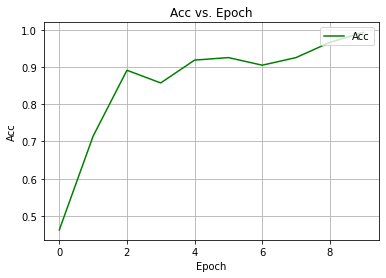

In [0]:
plt.grid()
#pyplot.plot(history_1.history['loss'],color='green')
pyplot.plot(history_2.history['categorical_accuracy'],color='green')
plt.title('Acc vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(['Acc'],loc='upper right')

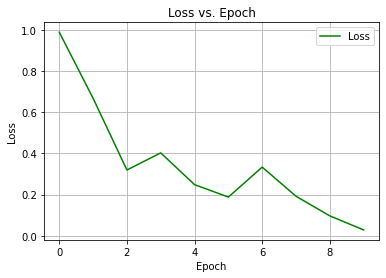

In [0]:
plt.grid()
#pyplot.plot(history_1.history['loss'],color='green')
pyplot.plot(history_2.history['loss'],color='green')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Loss'],loc='upper right')

# Test

In [0]:
#model1 for batch size 7
test_img1, test_label1 = next(test_batches)

test_loss1, test_acc1 = model1.evaluate(test_img1,  test_label1, verbose=2)
print('\nTest loss:', test_loss1)
print('\nTest accuracy:', test_acc1)


Test loss: 0.0034352652728557587

Test accuracy: 1.0


In [0]:
#model2 for batch size 3:

test_img2, test_label2 = next(test_batches)

test_loss2, test_acc2 = model2.evaluate(test_img2,  test_label2, verbose=2)
print('\nTest loss:', test_loss2)
print('\nTest accuracy:', test_acc2)


Test loss: 0.03873317688703537

Test accuracy: 1.0


In [0]:
print(test_label1)

print(test_label2)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [0]:
test_batches.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

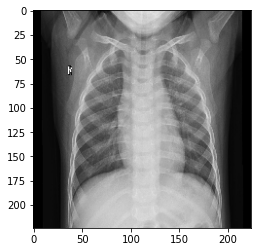

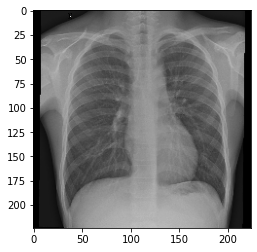

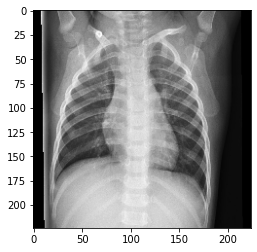

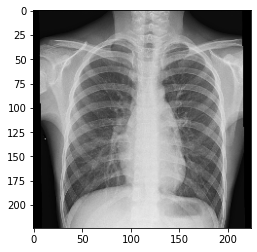

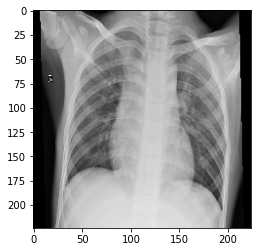

array([1., 1., 1., 1., 1.], dtype=float32)

In [0]:
#plot for batch size 7:
for i in range(0,5):
    image = test_img1[i]
    plt.imshow(image[:,:,0], cmap='gray')
    plt.show()   

test_label1[:,0]

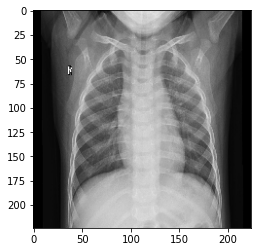

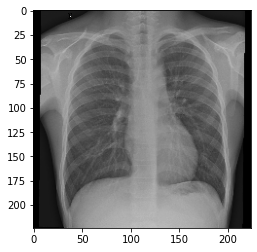

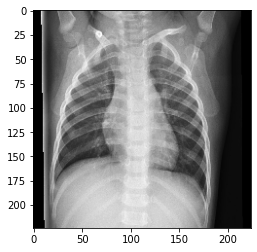

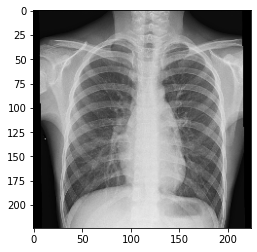

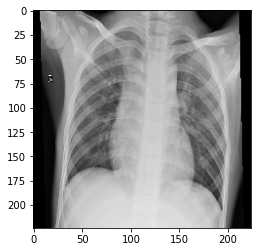

array([1., 1., 1., 1., 1.], dtype=float32)

In [0]:
#plot for batch size 3:
for i in range(0,5):
    image = test_img1[i]
    plt.imshow(image[:,:,0], cmap='gray')
    plt.show()   

test_label1[:,0]

In [0]:
# Generates predictions for the input samples from a data generator
#batch size 7:
predictor1=model1.predict_generator(test_batches,steps=1,verbose=0)

predictor1[:,0]

accuracy_score(test_label1[:,0], predictor1[:,0].round(), normalize=False)

confusion_matrix(test_label1[:,0],predictor1[:,0].round())

model1.save('norm_pneum_CNN.model1')

In [0]:
# Generates predictions for the input samples from a data generator
#batch size 3:
predictor2=model2.predict_generator(test_batches,steps=1,verbose=0)

predictor2[:,0]

accuracy_score(test_label2[:,0], predictor2[:,0].round(), normalize=False)

confusion_matrix(test_label2[:,0],predictor2[:,0].round())

model2.save('norm_pneum_CNN.model2')